In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from Savitzky_Golay import savitzky_golay
import scipy.stats as stats
import math

In [2]:
# This program:
#    1. computes the daily price spread as a proportion of the open price x10,000 (units are bps)
#    2. puts the spread data in a year x day matrix called 'spread_grid'
#    3. puts summary statistics for each day in a table called 'summary'
#    4. plots the adjusted average spread by day

# Notes:
#    - units are basis points (bps)
#    - adj avg spread = (mean + median)/2 - (.1 * stdev)
#    - spread as a proportion of the corresponding day's open accounts for growth

In [3]:
### Get the data from Yahoo Finance ###

# SPDR Gold Trust ticker
GLD = yf.Ticker('GLD')

# Historic market data
hist = GLD.history(period="max")

# Show the first and last rows
hist.head(1).append(hist.tail(1))

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-11-18,44.430000,44.490002,44.070000,44.380001,5992000,0,0
2019-11-08,137.729996,138.330002,137.389999,137.389999,10377400,0,0


In [4]:
### Create spread_grid ###

# 1. Get unique days and years from hist
unique_days = []
unique_years = []
for i, row in hist.iterrows():
    date = str(i)
    day = date[5:10]
    year = date[:4]
    unique_days = list(set(unique_days + [day]))
    unique_years = list(set(unique_years + [year]))

# 2. Give order to unique_days and unique_years
# a) num_day(day): turns day into an orderable int of the form MMDD
num_day = lambda day: int(day[:2] + day[3:])
unique_days.sort(key=num_day)
unique_years.sort()

# 3. Create df spread_grid, which stores daily spread (bps) = 10,000*(high-low)/open
spread_grid = pd.DataFrame(index = unique_days, columns = unique_years)
for i, row in hist.iterrows():
    date = str(i)[:10]
    day = date[5:10]
    year = date[:4]
    spread = 10000 * (row['High'] - row['Low']) / row['Open']
    spread_grid.at[day, year] = spread

# Show the first and last rows
spread_grid.head(1).append(spread_grid.tail(1))

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
01-02,NaN,NaN,NaN,NaN,203.446,89.6083,NaN,NaN,NaN,61.1658,83.1004,220.464,NaN,NaN,63.3724,71.6937
12-31,47.8903,NaN,NaN,102.731,331.843,80.5707,76.2087,NaN,123.058,232.964,149.709,40.4024,NaN,NaN,35.5431,NaN


In [5]:
### Create statistical summary ###

summary = pd.DataFrame(index = spread_grid.index.values)
summary['count'] = spread_grid.count(axis=1)
summary['std'] = spread_grid.std(axis=1)
summary['min'] = spread_grid.min(axis=1)
summary['mean'] = spread_grid.mean(axis=1)
summary['median'] = spread_grid.median(axis=1)
summary['max'] = spread_grid.max(axis=1)
summary['Q1'] = None
summary['Q3'] = None
summary['outlier range'] = None
summary['outlier count'] = None
# 'adj avg spread' is biased toward days with less spread variation
summary['adj avg spread'] = None
for i, row in summary.iterrows():
    summary.at[i, 'Q1'] = spread_grid.loc[i].quantile(.25)
    summary.at[i, 'Q3'] = spread_grid.loc[i].quantile(.75)
    # outlier range
    q1 = summary['Q1'][i]
    q3 = summary['Q3'][i]
    iqr = q3 - q1
    outlier_range = [q1 - (1.5 * iqr), q3 + (1.5 * iqr)]
    summary.at[i, 'outlier range'] = outlier_range
    # outlier count
    spreads = spread_grid.loc[i].values
    n_outliers = 0
    for spread in spreads:
        if spread < outlier_range[0] or spread > outlier_range[1]:
            n_outliers += 1
    summary.at[i, 'outlier count'] = n_outliers
    summary.at[i, 'adj avg spread'] = (row['mean'] + row['median'])/2 - 0.1 * row['std']

col_order = ['count', 'outlier range', 'outlier count', 'std', 'min', 'Q1','mean', 'adj avg spread', 'median', 'Q3', 'max']
summary = summary[col_order]

# Show the first and last rows
summary.head(1).append(summary.tail(1))

,count,outlier range,outlier count,std,min,Q1,mean,adj avg spread,median,Q3,max
01-02,7,"[-50.95828686495027, 265.01863860636684]",0,68.344308,61.165818,67.5331,113.264471,91.348,83.100429,146.527,220.464344
12-31,10,"[-77.14388088387825, 275.1595726835501]",1,94.824668,35.543089,54.9699,122.091910,97.389,91.650997,143.046,331.842738


In [6]:
### Sort Statistical Summary by mean spread ###

sortd = summary.sort_values(by='adj avg spread', ascending=False)

# Show the top and bottom five days in sortd
sortd.head(5).append(sortd.tail(5))

,count,outlier range,outlier count,std,min,Q1,mean,adj avg spread,median,Q3,max
02-29,3,"[-237.69792439385407, 670.7596700249483]",0,260.265705,99.498104,102.974,253.224749,153.81,106.449243,330.088,553.726901
09-18,11,"[-139.4170290282024, 416.7404257356143]",2,302.772572,51.328833,69.142,238.653660,149.212,120.325332,208.181,1038.717683
02-03,10,"[2.75713923775794, 260.3746916923936]",1,105.504728,57.029607,99.3637,159.186594,144.893,151.700115,163.768,417.506549
02-20,8,"[-20.750826766448583, 319.2927203042118]",0,67.950749,70.866262,106.766,155.431983,142.886,143.930492,191.776,281.813921
12-09,10,"[-19.109913623210147, 284.07545869693996]",0,64.193924,73.304168,94.5846,145.476884,138.646,144.653373,170.381,277.778328
06-22,11,"[0.6808050138556823, 136.2582772079524]",1,37.141587,24.956580,51.5224,70.535189,59.7584,56.409923,85.4167,163.314560
12-28,12,"[0.2703752456718149, 128.4665179999874]",1,54.385343,29.311237,48.3439,70.980385,58.2493,56.395377,80.393,233.689761
05-25,9,"[30.42472346283426, 83.2973247027061]",1,36.256925,34.303551,50.2519,66.078853,57.9906,57.153768,63.4701,155.958168
12-27,11,"[4.327181339537617, 101.88852701637865]",0,19.351338,37.704843,40.9127,56.429604,49.5542,46.549104,65.303,97.703401
12-24,8,"[-11.33822947041515, 97.96781743148662]",1,35.126751,23.043030,29.6515,53.571725,47.7136,48.880817,56.978,133.381649


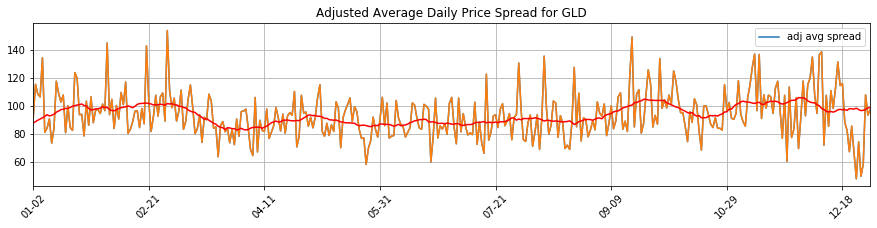

In [7]:
# 1. Get means from summary
adj_avg = summary[['adj avg spread']]

# 2. Plot means
graph_means = adj_avg.plot(title = 'Adjusted Average Daily Price Spread for GLD', 
                         figsize = (15,3),
                         grid=True,
                         rot = 45)

# 3. plot smoothed means
x = []
for i in range(0, adj_avg.shape[0]):
    x += [i]

y = summary['adj avg spread'].values
yhat = savitzky_golay(y, 51, 3) # window size 51, polynomial order 3

plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.show()

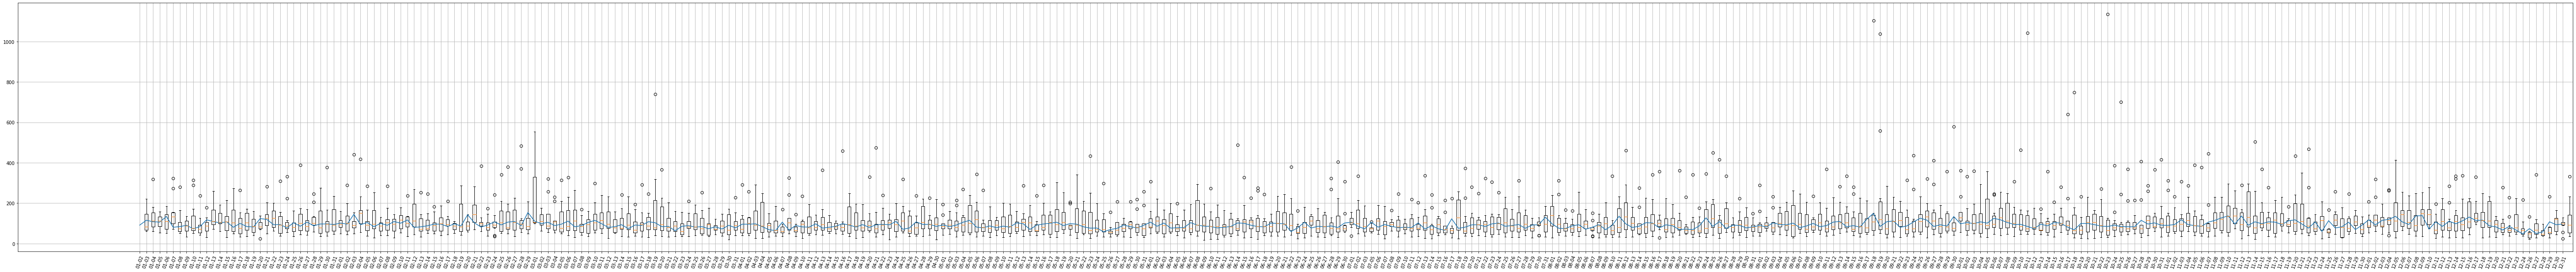

In [8]:
### Boxplots for all days ###

no_nan = []
for i, row in spread_grid.iterrows():
    clean_arr = np.array([])
    for val in row.values:
        if not pd.isna(val):
            clean_arr = np.append(clean_arr, val)
    no_nan += [clean_arr]    

# Create a figure instance
fig = plt.figure(figsize=(100, 10))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(no_nan)

# Create a grid
plt.grid()

# Create the x axis labels
x = []
for i in range(0,spread_grid.shape[0]):
    x += [i]
    
my_xticks = spread_grid.index.values
plt.xticks(x, my_xticks, rotation = 70)
plt.plot(x, y)
plt.show()

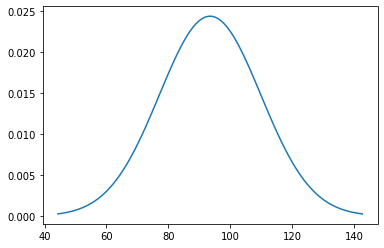

In [9]:
### Normal Distribution of adj avg spread ###

mu = summary['adj avg spread'].mean()
variance = summary['adj avg spread'].var()
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [10]:
# WIP
# remove outliers then do further analysis

In [11]:
### Boxplots of Days where pval >= .95 ###

# do this with data that has outliers removed

'''
# Get .975 p-value for adj avg spread
pval = stats.norm(mu, sigma).ppf(.975)

# Determine the point at which sortd falls below pval
cutpoint = 0
for i, row in sortd.iterrows():
    if row['adj avg spread'] <= pval:
        break
    cutpoint += 1

# Create df
top_days = sortd.head(cutpoint)

# Create boxplots
'''

"\n# Get .975 p-value for adj avg spread\npval = stats.norm(mu, sigma).ppf(.975)\n\n# Determine the point at which sortd falls below pval\ncutpoint = 0\nfor i, row in sortd.iterrows():\n    if row['adj avg spread'] <= pval:\n        break\n    cutpoint += 1\n\n# Create df\ntop_days = sortd.head(cutpoint)\n\n# Create boxplots\n"